<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/Valentines2009_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and unzip the relevant GCP data

In [164]:
# See https://global-mind.org/valentines.09.html for a description of the event
#grab the data - uncomment as needed

#! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-14.csv.gz
#! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-15.csv.gz #control1
#! wget -N -r -nH --cut-dirs=1 --limit-rate=125k https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-13.csv.gz #control2

--2023-09-05 10:35:55--  https://global-mind.org/data/eggsummary/2009/basketdata-2009-02-13.csv.gz
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5141417 (4.9M) [application/x-gzip]
Saving to: ‘eggsummary/2009/basketdata-2009-02-13.csv.gz’

eggsummary/2009/bas 100%[===================>]   4.90M   128KB/s    in 40s     

2023-09-05 10:36:35 (125 KB/s) - ‘eggsummary/2009/basketdata-2009-02-13.csv.gz’ saved [5141417/5141417]

FINISHED --2023-09-05 10:36:35--
Total wall clock time: 40s
Downloaded: 1 files, 4.9M in 40s (125 KB/s)


In [165]:
#unzip the data - uncomment as needed
#!gunzip eggsummary/2009/basketdata-2009-02-14.csv.gz
#!gunzip eggsummary/2009/basketdata-2009-02-15.csv.gz
#!gunzip eggsummary/2009/basketdata-2009-02-13.csv.gz

In [1]:
!ls eggsummary/2009

basketdata-2009-02-13.csv  basketdata-2009-02-14.csv  basketdata-2009-02-15.csv


In [2]:
#sanity check the download
!head eggsummary/2009/basketdata-2009-02-14.csv

10,1,10,"Samples per record"
10,2,10,"Seconds per record"
10,3,30,"Records per packet"
10,4,200,"Trial size"
11,1,61,"Eggs reporting"
11,2,1234569600,"Start time",2009-02-14 00:00:00
11,3,1234655999,"End time",2009-02-14 23:59:59
11,4,86400,"Seconds of data"
12,"gmtime",,1,28,37,102,103,105,110,111,112,116,118,119,142,226,228,231,237,1000,1022,1025,1051,1066,1070,1082,1092,1101,1223,2000,2001,2002,2006,2027,2028,2041,2042,2047,2049,2052,2060,2064,2069,2073,2080,2083,2084,2088,2091,2094,2097,2120,2173,2178,2220,2221,2222,2225,2230,2234,2235,2236,3043
13,1234569600,,111,103,100,105,90,96,95,85,104,104,104,102,94,89,92,103,108,101,105,90,108,112,109,94,88,92,102,88,88,97,111,96,103,95,104,100,109,95,106,104,87,102,106,102,115,100,111,100,103,104,116,100,107,99,113,,104,,103,93,90


Ingest the data and compute the chi-squared-minus-1 statistic for each second

In [1]:
#read in all the data

import pandas
eggdata_test = pandas.read_csv("eggsummary/2009/basketdata-2009-02-14.csv", skiprows=8)
eggdata_control1 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-15.csv", skiprows=8)
eggdata_control2 = pandas.read_csv("eggsummary/2009/basketdata-2009-02-13.csv", skiprows=8)

In [2]:
import numpy as np

def get_chisquareminus1(eggdata):
  #for ease of processing, convert all the eggdata columns to a numpy array
  #for the purpose of this analysis (since the null distribution is derived from
  # permutation), I don't try to filter out extreme values
  egg_values = np.array(eggdata.iloc[:, 3:])
  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1

#get the chisquare minus stat for the test and controls
csm1_test = get_chisquareminus1(eggdata_test)
csm1_control1 = get_chisquareminus1(eggdata_control1)
csm1_control2 = get_chisquareminus1(eggdata_control2)

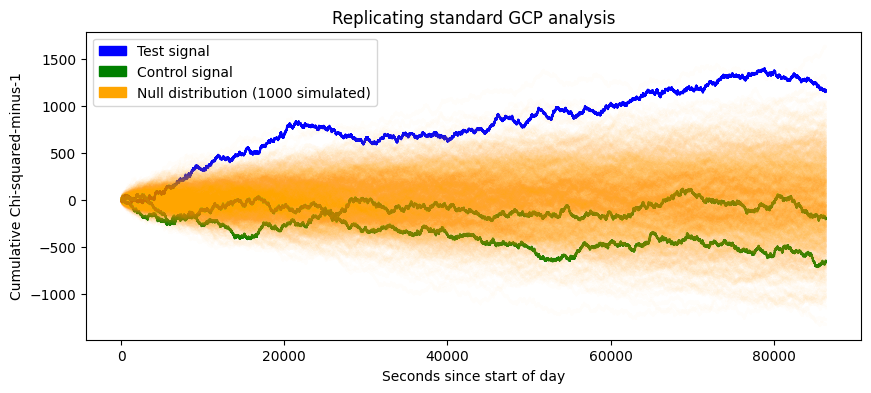

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

#replicate the figure at https://global-mind.org/valentines.09.html
fig = plt.figure(figsize=(10,4))
plt.plot(np.arange(len(csm1_test)),np.cumsum(csm1_test), color="blue")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(csm1_control1), color="green")
plt.plot(np.arange(len(csm1_control1)),np.cumsum(csm1_control2), color="green")

#also plot 1000 simulated controls from pseudorandom data
rng = np.random.RandomState(1234)
for i in range(1000):
  sim_csm1 = np.square(rng.normal(size=len(csm1_test)))-1
  plt.plot(np.arange(len(sim_csm1)),np.cumsum(sim_csm1), color="orange", alpha=0.02)
plt.title("Replicating standard GCP analysis")
plt.xlabel("Seconds since start of day")
plt.ylabel("Cumulative Chi-squared-minus-1")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signal'),
                    mpatches.Patch(color='orange', label='Null distribution (1000 simulated)')],
           loc="upper left")
plt.show()

Now analyze the power spectra

In [4]:
import scipy
#let's check if the power spectrum of the data shows any biases

def get_normalized_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

ps_test = get_normalized_power_spectrum(csm1_test)
ps_control1 = get_normalized_power_spectrum(csm1_control1)
ps_control2 = get_normalized_power_spectrum(csm1_control2)

#permute the test data sequence 1000 times to get an empirical null
rng = np.random.RandomState(1234)
ps_permutetest_list = np.array([get_normalized_power_spectrum(rng.permutation(csm1_test)) for i in range(1000)])

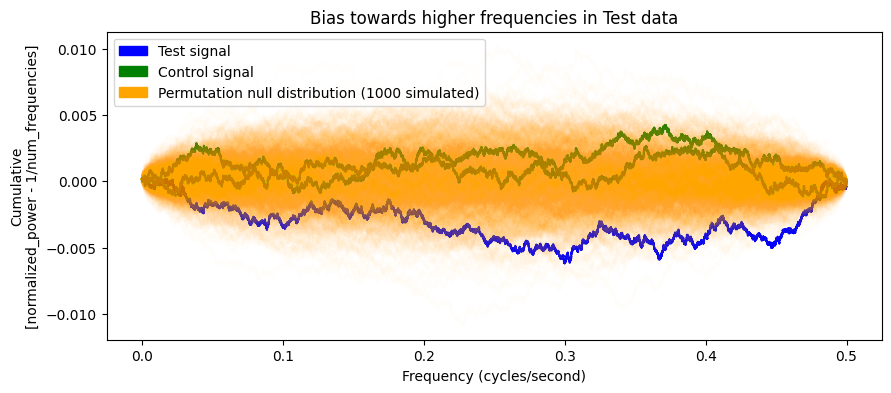

In [5]:
freqs = np.fft.rfftfreq(len(csm1_test), 1) #get the frequencies
uniform_expectation = 1.0/len(ps_test) #what you expect for each frequency if the power spectrum is perfectly uniform

#plot the cumulative sum of the normalized power spectrum relative to a perfectly uniform power spectrum
plt.figure(figsize=(10,4))
plt.plot(freqs, np.cumsum(ps_test - uniform_expectation), color="blue")
plt.plot(freqs, np.cumsum(ps_control1 - uniform_expectation), color="green")
plt.plot(freqs, np.cumsum(ps_control2 - uniform_expectation), color="green")
#Also plot the 1000 power spectra from the permuted test data
for ps_permutetest in ps_permutetest_list:
  plt.plot(freqs, np.cumsum(ps_permutetest - uniform_expectation), color="orange", alpha=0.02)
plt.ylabel("Cumulative\n[normalized_power - 1/num_frequencies]")
plt.xlabel("Frequency (cycles/second)")
plt.title("Bias towards higher frequencies in Test data")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signal'),
                    mpatches.Patch(color='orange', label='Permutation null distribution (1000 simulated)')],
           loc="upper left")
plt.show()

Test p value: 0.01
Control 1 p value: 0.661
Control 2 p value: 0.859


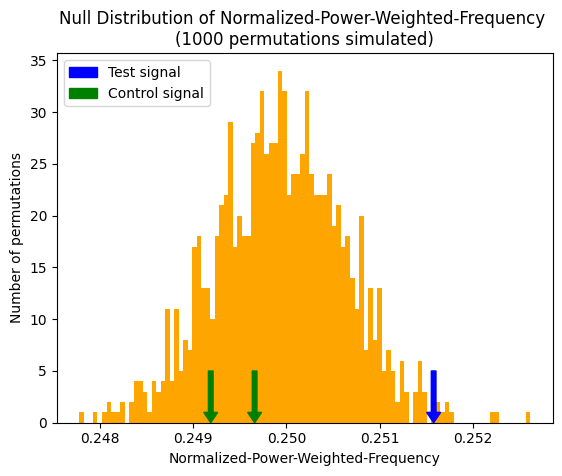

In [6]:
#looks like there is a bias towards higher frequencies in the test signal.
#We can check this by summing the frequencies weighted by their corresponding
# normalized power for both the signal and the controls

#npwf = normalized power weighted frequency
npwf_permutetest_list = np.sum(freqs[None,:]*ps_permutetest_list, axis=1);

npwf_test = np.sum(freqs*ps_test)
npwf_control1 = np.sum(freqs*ps_control1)
npwf_control2 = np.sum(freqs*ps_control2)

pvalue_test = np.sum(npwf_permutetest_list >= npwf_test)/len(npwf_permutetest_list)
pvalue_control1 = np.sum(npwf_permutetest_list >= npwf_control1)/len(npwf_permutetest_list)
pvalue_control2 = np.sum(npwf_permutetest_list >= npwf_control2)/len(npwf_permutetest_list)

print("Test p value:",pvalue_test)
print("Control 1 p value:",pvalue_control1)
print("Control 2 p value:",pvalue_control2)

plt.hist(npwf_permutetest_list, bins=100, color="orange")
plt.arrow(npwf_test, 5, 0, -5, color="blue", head_length=1, length_includes_head=True, width=0.00005)
plt.arrow(npwf_control1, 5, 0, -5, color="green", head_length=1, length_includes_head=True, width=0.00005)
plt.arrow(npwf_control2, 5, 0, -5, color="green", head_length=1, length_includes_head=True, width=0.00005)
plt.xlabel("Normalized-Power-Weighted-Frequency")
plt.ylabel("Number of permutations")
plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signal')],
           loc="upper left")
plt.title("Null Distribution of Normalized-Power-Weighted-Frequency \n(1000 permutations simulated)")

plt.show()